#### **GPU info**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

#### **Python imports for this project**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import itertools
from tqdm import tqdm
import cv2

import torch
import torchvision

import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from google.colab.patches import cv2_imshow
from google.colab import files

import shutil

####  **Import datasets**

The datasets consist of a set of monet paintings and a set of real-world images, most of them being photos of landscapes.


The easiest way to import them is from Kaggle. In order to do that, you have to manually upload your **kaggle.json** file first. Then, the following scripts fetch the datasets locally by making use of the kaggle CLI.




In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d balraj98/monet2photo
!unzip monet2photo.zip
!kaggle competitions download gan-getting-started
!unzip gan-getting-started.zip

####  **Helper functions**



*   **de_norm(input)** - de-normalizes the array given as parameter and returns the result.
*   **visualization(x, y, z, save = False, path = "")** - uses matplotlib to visualize a tuple of 3 images that we pass as parameters. In our use-case, we'll want to visualize tuples consisting of a landscape photo, its translation to a Monet-esque painting and the reverse translation of the Monet-esque variant back to a 'real' image.



In [ ]:
#  Functii care ne ajuta sa vizualizam rezultatele retelei

def de_norm(input):
    mean = 0.5 
    std = 0.5
    return input * std + mean

def visualization(x, y, z, save = False, path = ''):
    x = torch.reshape(x, (3, 256, 256))
    y = torch.reshape(y, (3, 256, 256))
    z = torch.reshape(z, (3, 256, 256))

    x = x.cpu().detach().numpy().transpose(1,2,0)
    y = y.cpu().detach().numpy().transpose(1,2,0)
    z = z.cpu().detach().numpy().transpose(1,2,0)

    x = de_norm(x)
    y = de_norm(y)
    z = de_norm(z)
    
    plt.figure(figsize = (16,8))
    plt.subplot(1,3,1)
    plt.title('actual')
    plt.imshow(x)
    plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
    plt.subplot(1,3,2)
    plt.title('fake')
    plt.imshow(y)
    plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
    plt.subplot(1,3,3)
    plt.title('cycle')
    plt.imshow(z)
    plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)

    if save == True:
        plt.savefig(path)
    else:
        plt.show()

#### **Building our PyTorch dataset**

The original paper on which this project is based used ~300 Monet paintings and ~7000 real images to train the model. After a little bit of research, I found a dataset that contains ~1000 Monet paintings and the same amount of real images, which helps our model learn Monet's style better.

Since the scope of this notebook is to implement an Unpaired Image-to-Image Translation between real-world photos and Monet paintings, we don't want our dataset to return the same pairs of photos and Monet paintings each time we iterate through it - because that would turn our algorithm into a paired image-to-image translation.

So, for each (Monet, photo) pair we choose a random Monet painting and a random photo. (lines 19, 20)

Therefore, the length of the dataset essentially means how many of these pairs do we want to iterate through for each epoch of training. I found 1000 to be a good number, because we have ~1000 Monet paintings in our dataset and so we expect each of them to appear roughly once in 1000 such pairs of images. 

Another observation here: the length of the dataset can be balanced with the number of epochs of training. A big dataset length would mean more training for every epoch, which is not really ideal.

For dataset transformations, I used only resizing and normalization. Random translations, cut-outs, contrast changes or any such transformations result in our model performing worse - which is understandable, because the task of the model is to learn the specific style of a given set of images. Making cut-outs or altering the image colors gives less Monet-esque results.

In [42]:
class CustomDataset(Dataset):

    def __init__(self, monet_dir, photo_dir, monet_files, photo_files, transforms = None, seed = 2010):
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.monet = monet_files
        self.photo = photo_files
        self.seed = seed
        self.transforms = transforms
        

    def __len__(self):
        return 1000

    #  Function that returns a pair consisting of:
    #       -- a random monet painting
    #       -- a random photo
    def __getitem__(self, idx):
        monet_path = self.monet_dir + self.monet[np.random.randint(0, len(self.monet))]
        photo_path = self.photo_dir + self.photo[np.random.randint(0, len(self.photo))]

        monet_img = Image.open(monet_path).convert('RGB')
        photo_img = Image.open(photo_path).convert('RGB')

        if self.transforms:
            photo = self.transforms(photo_img)
        monet = self.transforms(monet_img)
        return monet, photo

monet_files = os.listdir('trainA')
photo_files = os.listdir('trainB')
monet_test_files = os.listdir('testA')
photo_test_files = os.listdir('photo_jpg')

transforms = T.Compose([
    T.Resize(size = (256, 256)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = CustomDataset('trainA/', 'trainB/', monet_files, photo_files, transforms = transforms)
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 2)
test_dataset = CustomDataset('testA/', 'testB/', monet_test_files, photo_test_files, transforms = transforms)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = True, num_workers = 2)


#### **Generator definition**

In the paper 2 types of generator architectures are analyzed:
*   one that uses residual blocks
*   one that uses the U-Net architecture with skip connections

I implemented and played around with both. For this task, the U-Net architecture gives better results.



In [ ]:
class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act = True, **kwargs):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode = 'reflect', **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace = True) if use_act
            else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act = True, **kwargs):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 0),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace = True) if use_act
            else nn.Identity()
        )


    def forward(self, x):
        return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            DownsampleBlock(channels, channels, kernel_size = 3, padding = 1),
            DownsampleBlock(channels, channels, use_act = False, kernel_size = 3, padding = 1)
        )

    def forward(self, x):
        #  Skip connections
        return x + self.block(x)


class GeneratorResnet(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.downsample = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 1, padding = 3, padding_mode = 'reflect'),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace = True),
            DownsampleBlock(64, 128, kernel_size = 3, stride = 2, padding = 1),
            DownsampleBlock(128, 256, kernel_size = 3, stride = 2, padding = 1),
        )

        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(256) for _ in range(9)]
        )

        self.upsample = nn.Sequential(
            UpsampleBlock(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            UpsampleBlock(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.Conv2d(64, 3, kernel_size = 7, stride = 1, padding = 3, padding_mode = 'reflect')
        )


    def forward(self, x):
        x = self.downsample(x)
        x = self.residual_blocks(x)
        x = self.upsample(x)
        return torch.tanh(x)

In [ ]:
#  Inspiration: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/003efc4c8819de47ff11b5a0af7ba09aee7f5fc1/models/networks.py#L436
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, in_channels = None, submodule = None, outermost = False, innermost = False, use_dropout = False):
        '''
            Constructs a Unet submodule with skip connections.

            Parameters:
                outer_nc                                      --- number of channels in the outer conv layer
                inner_nc                                      --- number of channels in the inner conv layer
                in_channels                                   --- number of channels in input data
                submodule (UnetSkipConnectionBlock)           --- previously defined submodules
                outermost (bool)                              --- if this is the outermost module
                innermost (bool)                              --- if this is the innermost module
                use_dropout (bool)                            --- whether to use dropout layers or not
        '''
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost

        if in_channels is None:
            in_channels = outer_nc

        down_conv = nn.Conv2d(in_channels, inner_nc, kernel_size = 4, stride = 2, padding = 1, bias = False)
        down_relu = nn.LeakyReLU(0.2, True)
        down_norm = nn.InstanceNorm2d(inner_nc)
        up_relu = nn.ReLU(True)
        up_norm = nn.InstanceNorm2d(outer_nc)

        if outermost:
            up_conv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size = 4, stride = 2, padding = 1)
            down = [down_conv]
            #up = [up_relu, nn.Upsample(scale_factor = 2, mode='bilinear'), nn.ReflectionPad2d(1), nn.Conv2d(inner_nc * 2, outer_nc, kernel_size = 3, stride = 1, padding = 0, bias = False), nn.Tanh()]
            up = [up_relu, up_conv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            up_conv = nn.ConvTranspose2d(inner_nc, outer_nc, kernel_size = 4, stride = 2, padding = 1, bias = False)
            down = [down_relu, down_conv]
            #up = [up_relu, nn.Upsample(scale_factor = 2, mode='bilinear'), nn.ReflectionPad2d(1), nn.Conv2d(inner_nc, outer_nc, kernel_size = 3, stride = 1, padding = 0, bias = False), up_norm]
            up = [up_relu, up_conv, up_norm]
            model = down + up
        else:
            up_conv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size = 4, stride = 2, padding = 1, bias = False)
            down = [down_relu, down_conv, down_norm]
            #up = [up_relu, nn.Upsample(scale_factor = 2, mode='bilinear'), nn.ReflectionPad2d(1), nn.Conv2d(inner_nc * 2, outer_nc, kernel_size = 3, stride = 1, padding = 0, bias = False), up_norm]
            up = [up_relu, up_conv, up_norm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)


class Generator(nn.Module):
    def __init__(self, num_downs, in_channels = 3, out_channels = 3, use_dropout = False):
        super(Generator, self).__init__()

        #  Add the innermost layer
        unet_block = UnetSkipConnectionBlock(512, 512, in_channels = None, submodule = None, innermost = True)
        
        #  Add intermediate layers with 512 filters
        for i in range(num_downs - 5):
            unet_block = UnetSkipConnectionBlock(512, 512, in_channels = None, submodule = unet_block, use_dropout = use_dropout)
        
        #  Gradually reduce the number of filters (channels)
        unet_block = UnetSkipConnectionBlock(256, 512, in_channels = None, submodule = unet_block)
        unet_block = UnetSkipConnectionBlock(128, 256, in_channels = None, submodule = unet_block)
        unet_block = UnetSkipConnectionBlock(64, 128, in_channels = None, submodule = unet_block)

        #  Add the outermost layer
        self.model = UnetSkipConnectionBlock(out_channels, 64, in_channels = in_channels, submodule = unet_block, outermost = True)


    def forward(self, input):
        return self.model(input)

#### **Discriminator definition**

The architecture for our discriminator is called PatchGAN.
The main idea behind it is that instead of a binary classifier over the whole image, where we give an image as an input and receive 0 or 1 as output, we implement a binary classifier over smaller patches of the initial image. The result will be a matrix, where each entry specifies whether a given patch of the initial image is 0 or 1 - one can also say that the output neurons have a big receptive field in the initial image. The reasoning behind choosing this architecture is that we want our classifier to look at smaller scale details, such as textures or brush patterns, which tend to be overlooked otherwise.

In [ ]:
#  PatchGAN

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.layers = []
        self.layers += self.conv_block(3, 64, stride = 2, use_norm = False)
        self.layers += self.conv_block(64, 128, stride = 2)
        self.layers += self.conv_block(128, 256, stride = 2)
        self.layers += self.conv_block(256, 512)
        self.layers += self.conv_block(512, 1, use_act = False, use_norm = False)
        #self.layers += [nn.Sigmoid()]
        self.net = nn.Sequential(*self.layers)


    def forward(self, x):
        return self.net(x)


    def conv_block(self, in_channels, out_channels, stride = 1, padding = 2, use_norm = True, use_act = True):
        layers = []

        layers += [nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size = 4,
            stride = stride,
            padding = padding,
            padding_mode = 'reflect',
            bias = True
        )]

        if use_norm:
            layers += [nn.InstanceNorm2d(out_channels)]

        if use_act:
            layers += [nn.LeakyReLU(0.2, inplace = True)]

        return layers

####  **Differentiable Augmentation**

This part of the code is based on the following paper: Differentiable Augmentation for Data-Efficient GAN Training (https://arxiv.org/pdf/2006.10738.pdf).

A strategy that is used to reduce overfitting in image classification is data augmentation. However, in the case of training GANs, if we apply data augmentation to the real images, then the generator will be encouraged to perform a transformation that matches the distribution of *augmented images* instead of the distribution of the *real images*, which is not what we want.

To tackle this problem, the aforementioned paper introduces a method called **DiffAugment**, which only applies augmentations to the images that are fed into a discriminator - more precisely, the transformation is apllied right before the images are fed into the discriminator.

The official code for the paper can be found here: https://github.com/mit-han-lab/data-efficient-gans/blob/master/DiffAugment-stylegan2/DiffAugment_tf.py.

The code snippet below is taken from that repo. For our task, I found that *cutout* and *translation* make our model perform worse (after enough epochs of training, the generator overfits and all the generated images end up having gray or black spots in the middle of them). Therefore, I kept only the color transformations (lines 70-71).

After some experimenting, I found that the results of our CycleGAN have a better FID score when training using DiffAUG (usually the FID score of our model is 3-4 units lower than the FID score obtained when training without DiffAug).

In [ ]:
def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2).contiguous()
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

def aug_fn(image):
    return DiffAugment(image, 'color')

In [ ]:
def test_diffaug(image):
    for i in range(10):
        aug_image = aug_fn(image)
        visualization(image, aug_image[0], image)

x = train_dataset[0][0]
x = x.unsqueeze(0)
test_diffaug(train_dataset[0][1])

#### **Training configuration**

This block of code defines the variables that we work with when training the network, namely:
*   the generator and discriminator networks
*   optimizers
*   loss functions
*   gradient scalers



In [31]:
#  Training parameters
lr = 1e-5
num_epochs = 50
lambda_net = 20
lambda_identity = 0.5

#  Models
disc_photo = Discriminator().cuda()  #  Is the image a real/fake photo?
disc_monet = Discriminator().cuda()  #  Is the image a real/fake Monet?
gen_photo = Generator(8, use_dropout = True).cuda()  #  Monet ---> photo
gen_monet = Generator(8, use_dropout = True).cuda()  #  photo ---> Monet

disc_photo = torch.load('drive/MyDrive/net_params/v16_399_disc_photo.pth').cuda()
disc_monet = torch.load('drive/MyDrive/net_params/v16_399_disc_monet.pth').cuda()
gen_photo = torch.load('drive/MyDrive/net_params/v16_399_gen_photo.pth').cuda()
gen_monet = torch.load('drive/MyDrive/net_params/v16_399_gen_monet.pth').cuda()

#  Optimizers
opt_disc = optim.Adam(
    itertools.chain(disc_monet.parameters(), disc_photo.parameters()),
    lr = lr,
    betas = (0.5, 0.999)
)

opt_gen = optim.Adam(
    itertools.chain(gen_monet.parameters(), gen_photo.parameters()),
    lr = lr,
    betas = (0.5, 0.999)
)

opt_disc.zero_grad()
opt_gen.zero_grad()

#  Loss functions
L1 = nn.L1Loss().cuda()  #  cycle consistency loss & identity loss
MSE = nn.BCEWithLogitsLoss().cuda()  #  adversarial loss

#  Scalers
gen_scaler = torch.cuda.amp.GradScaler()
disc_scaler = torch.cuda.amp.GradScaler()

#### **Helper functions for training**

The next functions are really helpful when training and testing our model.


*   **save_model_configuration(epoch)** - saves the generator and discriminator model parameters to Google Drive
*   **eval_visually(epoch, to_show)** - helps us visualize the results of our model on a number of images specified by *to_show*
*   **plot_values(values, title)** - plots and shows loss function values given as parameters
*   **update_req_grad(models, requires_grad)** - changes the gradient requirements for a given model. When training our CycleGAN, we train the discriminators and generators separately. When we train the discriminators we don't want the generator parameters to get updated and vice-versa. This is where this function comes in.
*   **init_weights(m)** - initializes the weights of the model given as parameter so that they follow a normal distribution with mean 0 and standard deviation 0.02



In [ ]:
def save_model_configuration(epoch):
    print('Saving model parameters after epoch %d...' % epoch)
    torch.save(disc_photo, 'drive/MyDrive/net_params/v19_%d_disc_photo.pth' % epoch)
    torch.save(disc_monet, 'drive/MyDrive/net_params/v19_%d_disc_monet.pth' % epoch)
    torch.save(gen_photo, 'drive/MyDrive/net_params/v19_%d_gen_photo.pth' % epoch)
    torch.save(gen_monet, 'drive/MyDrive/net_params/v19_%d_gen_monet.pth' % epoch)
    #torch.save(opt_disc.state_dict(), 'drive/MyDrive/net_params/v7_%d_opt_disc.pth' % epoch)
    #torch.save(opt_gen.state_dict(), 'drive/MyDrive/net_params/v7_%d_opt_gen.pth' % epoch)

In [ ]:
save_model_configuration(199)

Saving model parameters after epoch 199...


In [32]:
def eval_visually(epoch, to_show = 2):
    disc_photo.eval()
    disc_monet.eval()
    gen_photo.eval()
    gen_monet.eval()

    for i, (monet, photo) in enumerate(train_dataloader):
        monet = monet.cuda()[0].unsqueeze(0)
        photo = photo.cuda()[0].unsqueeze(0)

        if i < to_show:
            generated_monet = gen_monet(photo)
            cycled_photo = gen_photo(generated_monet)
            visualization(photo, generated_monet, cycled_photo)
        else:
            break

In [14]:
def plot_values(values: list, title: str):
    plt.plot(values)
    plt.title(title)
    plt.show()

In [15]:
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [ ]:
def init_weights(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)

#### **Training function**

This is where the actual training of the model happens. 

Feel free to comment the first 4 lines if you want to continue training a model, otherwise the parameters will get reset.

As I mentioned before, the discriminators and generators are trained separately.

This function was inspired by the paper authors' code, which is publically available on github: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.

The average discriminator and generator losses are printed to console after each epoch of training. Every 5 epochs we visualize the results of our model on 10 random pictures in the training set.


In [ ]:
disc_photo.apply(init_weights)
disc_monet.apply(init_weights)
gen_photo.apply(init_weights)
gen_monet.apply(init_weights)


disc_losses = []
gen_losses = []
regularization_losses = []

#  Let's see what 'completely random' looks like
eval_visually(0)

for epoch in range(0, 0 + num_epochs):    
    disc_photo.train()
    disc_monet.train()
    gen_photo.train()
    gen_monet.train()

    epoch_disc_loss = 0
    epoch_gen_loss = 0
    epoch_regularization_loss = 0
    num_iterations = 0

    for i, (monet, photo) in enumerate(train_dataloader):
        num_iterations += 1
        monet = monet.cuda()
        photo = photo.cuda()

        #  Train Discriminators
        update_req_grad([disc_photo, disc_monet], True)
        update_req_grad([gen_photo, gen_monet], False)
        with torch.cuda.amp.autocast():
            #  Monet disciminator
            fake_monet = gen_monet(photo)
            aug_monet = torch.cat((monet, fake_monet), dim = 0)
            aug_monet = aug_fn(aug_monet)
            aug_real_monet = aug_monet[:8]
            aug_fake_monet = aug_monet[8:]

            pred_monet_real = disc_monet(aug_real_monet.detach())
            pred_monet_fake = disc_monet(aug_fake_monet.detach())
            disc_monet_loss_real = MSE(pred_monet_real, torch.ones_like(pred_monet_real))
            disc_monet_loss_fake = MSE(pred_monet_fake, torch.zeros_like(pred_monet_fake))
            disc_monet_loss = disc_monet_loss_real + disc_monet_loss_fake

            #  Photo disciminator
            fake_photo = gen_photo(monet)
            pred_photo_real = disc_photo(photo)
            pred_photo_fake = disc_photo(fake_photo.detach())
            disc_photo_loss_real = MSE(pred_photo_real, torch.ones_like(pred_photo_real))
            disc_photo_loss_fake = MSE(pred_photo_fake, torch.zeros_like(pred_photo_fake))
            disc_photo_loss = disc_photo_loss_real + disc_photo_loss_fake

            disc_loss = (disc_monet_loss + disc_photo_loss) / 2
            epoch_disc_loss += disc_loss.item()

        opt_disc.zero_grad()
        disc_scaler.scale(disc_loss).backward()
        disc_scaler.step(opt_disc)
        disc_scaler.update()

        #  Train Generators
        update_req_grad([disc_photo, disc_monet], False)
        update_req_grad([gen_photo, gen_monet], True)
        with torch.cuda.amp.autocast():
            fake_monet = gen_monet(photo)
            fake_photo = gen_photo(monet)
            
            #  adversarial loss
            pred_monet_fake = disc_monet(fake_monet)
            pred_photo_fake = disc_photo(fake_photo)
            adversarial_loss_monet = MSE(pred_monet_fake, torch.ones_like(pred_monet_fake))
            adversarial_loss_photo = MSE(pred_photo_fake, torch.ones_like(pred_photo_fake))

            #  cycle loss
            cycled_photo = gen_photo(fake_monet)
            cycled_monet = gen_monet(fake_photo)
            cycle_loss_photo = L1(photo, cycled_photo)
            cycle_loss_monet = L1(monet, cycled_monet)

            #  identity loss
            identity_photo = gen_photo(photo)
            identity_monet = gen_monet(monet)
            identity_loss_photo = L1(photo, identity_photo)
            identity_loss_monet = L1(monet, identity_monet)

            #  Generator loss
            generator_loss = (
                adversarial_loss_monet
                + adversarial_loss_photo
                + cycle_loss_photo * lambda_net
                + cycle_loss_monet * lambda_net
                + identity_loss_photo * lambda_net * lambda_identity
                + identity_loss_monet * lambda_net * lambda_identity
            )
            epoch_gen_loss += generator_loss.item()
            epoch_regularization_loss += (
                cycle_loss_photo.item() * lambda_net
                + cycle_loss_monet.item() * lambda_net
                + identity_loss_photo.item() * lambda_net * lambda_identity
                + identity_loss_monet.item() * lambda_net * lambda_identity
            )

        opt_gen.zero_grad()
        gen_scaler.scale(generator_loss).backward()
        gen_scaler.step(opt_gen)
        gen_scaler.update()

    epoch_gen_loss /= num_iterations
    epoch_disc_loss /= num_iterations
    epoch_regularization_loss /= num_iterations
    gen_losses.append(epoch_gen_loss)
    disc_losses.append(epoch_disc_loss)
    regularization_losses.append(epoch_regularization_loss)
    
    print('[Epoch %3d/%d] gen_loss: %.4f; disc_loss: %.4f' % (epoch, num_epochs, gen_losses[-1], disc_losses[-1]))

    if epoch % 10 == 9:
        save_model_configuration(epoch + 210)  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        plot_values(gen_losses, 'Generator Loss')
        plot_values(disc_losses, 'Discriminator loss')
        plot_values(regularization_losses, 'Cycle + Identity Loss')

    if epoch % 5 == 4:
        eval_visually(epoch, to_show = 10)
        



plot_values(disc_losses, 'Discriminator Loss')
plot_values(gen_losses, 'Generator Loss')

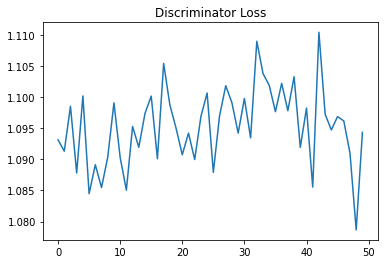

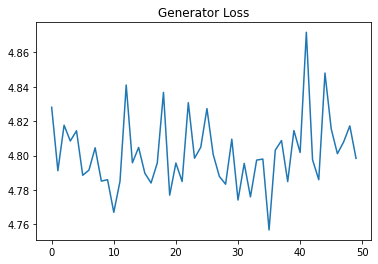

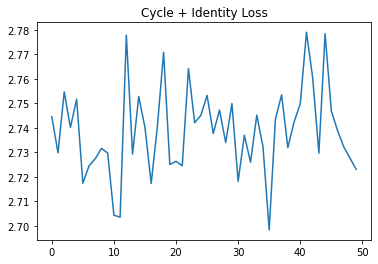

In [ ]:
plot_values(disc_losses, 'Discriminator Loss')
plot_values(gen_losses, 'Generator Loss')
plot_values(regularization_losses, 'Cycle + Identity Loss')

In [ ]:
print(gen_losses)
print(disc_losses)

[4.602043945397904, 4.503541403741979, 4.4736412194237785, 4.443714239704075, 4.511151223040339, 4.434565344853188, 4.40209516660491, 4.377492931351733, 4.382314504082523, 4.331078452850456, 4.3320628813843225, 4.354857281072816, 4.281908385789216, 4.207544278742662, 4.236779335719436, 4.186467099545607, 4.201374792340976, 4.206556154720819, 4.169454606611337, 4.18770983147977, 4.147189065591613, 4.154524680393846, 4.152400417114372, 4.051452661628153, 4.0735760606936555, 4.101562409258601, 4.048699798868664, 4.028153205985453, 4.071272524435129, 4.079023354089082, 4.021052876515175, 3.9872026568028462, 3.9530671923907836, 3.988149851115782, 3.996791234656946, 3.949143439976137, 3.969605728761474, 3.9226963715766794, 3.862102061954897, 3.859409864269086, 3.878556824442166, 4.124436487012835, 3.8899754712830727, 3.921869685400778, 3.825265678007211, 3.82898658602985, 3.820005135749703, 3.856852328599389, 3.7767896598844386, 3.7816760451046387, 3.783237446599932, 3.758605343192371, 3.738

####  **Making predictions**

Once the model is trained, the following snippets of code allow us to generate the results for all input images and then archive them.

I ended up generating the results on Kaggle and then downloading them from there (since that is the only way that Kaggle can score your submission for this competition), that's why the code below is a bit messy. Not the best coding practice, but...

In [ ]:
!mkdir output

In [ ]:
#  Make predictions
def make_predictions():
    file_names = os.listdir('photo_jpg')

    to_image = T.ToPILImage()

    num_iter = 10
    for file_name in file_names:
        num_iter -= 1
        if num_iter < 0:
            break

        path = 'photo_jpg/' + file_name
        image = Image.open(path).convert('RGB')
        image = transforms(image)
        image = image.unsqueeze(0)
        image = image.cuda()
        generated_monet = gen_monet(image)
        #cycled_image = gen_photo(generated_monet)

        #visualization(image, generated_monet, cycled_image)

        generated_monet = torch.reshape(generated_monet, (3, 256, 256))
        generated_monet = de_norm(generated_monet)
        generated_monet = to_image(torch.tensor(generated_monet))
        generated_monet = np.asarray(generated_monet)
        generated_monet = cv2.cvtColor(generated_monet, cv2.COLOR_BGR2RGB)

        #cv2.imwrite('output/' + file_name, generated_monet)
        cv2_imshow(generated_monet)

    print('Finished!')

#gen_monet = torch.load('drive/MyDrive/net_params/v7_39_gen_monet.pth')
#gen_photo = torch.load('drive/MyDrive/net_params/v7_39_gen_photo.pth')
gen_monet = gen_monet.cuda()
gen_photo = gen_photo.cuda() 
gen_monet.eval()
gen_photo.eval()
make_predictions()

In [ ]:
shutil.make_archive('arhiva', 'zip', 'output/')

'/content/arhiva.zip'

In [ ]:
files.download('arhiva.zip')

FileNotFoundError: ignored

In [ ]:
gen_photo = torch.load('drive/MyDrive/net_params/v16_399_gen_photo.pth').cuda()
gen_monet = torch.load('drive/MyDrive/net_params/v16_399_gen_monet.pth').cuda()
disc_photo = torch.load('drive/MyDrive/net_params/v16_399_disc_photo.pth').cuda()
disc_monet= torch.load('drive/MyDrive/net_params/v16_399_disc_monet.pth').cuda()


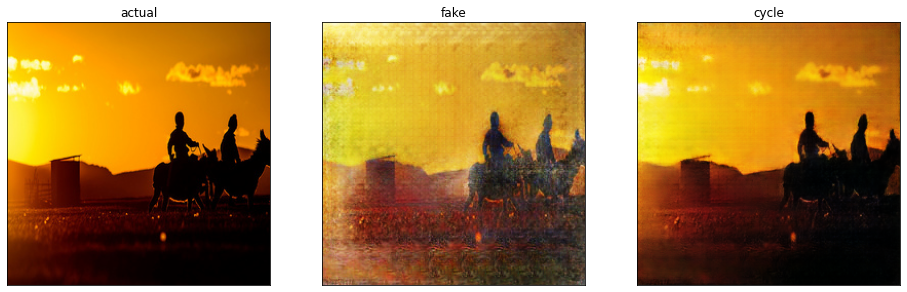

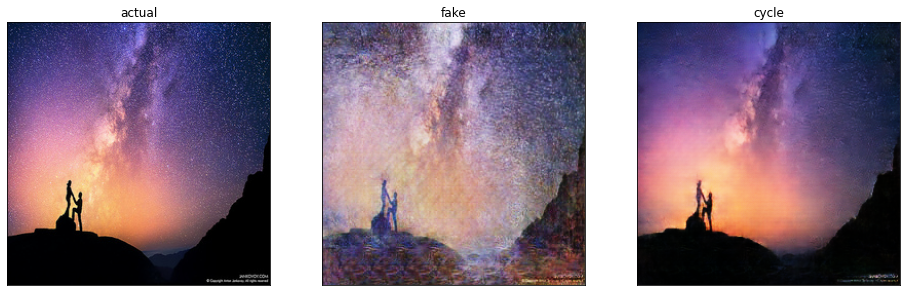

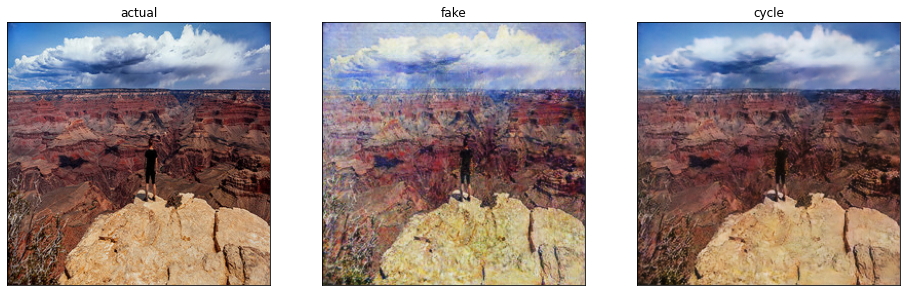

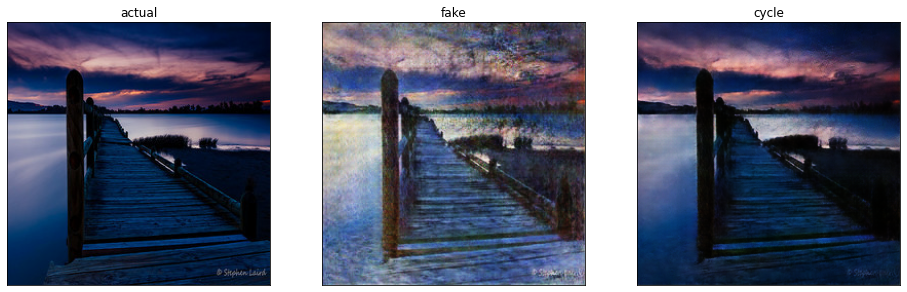

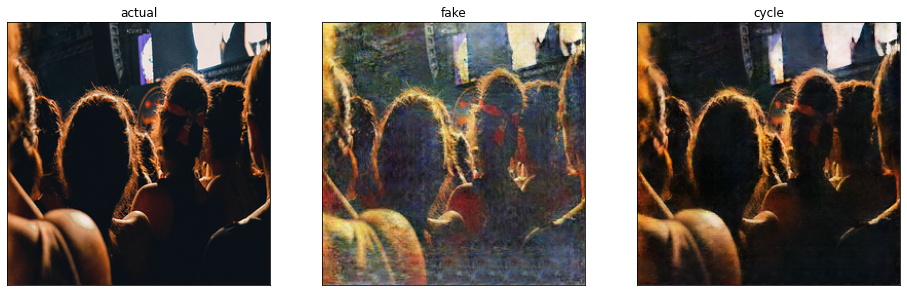

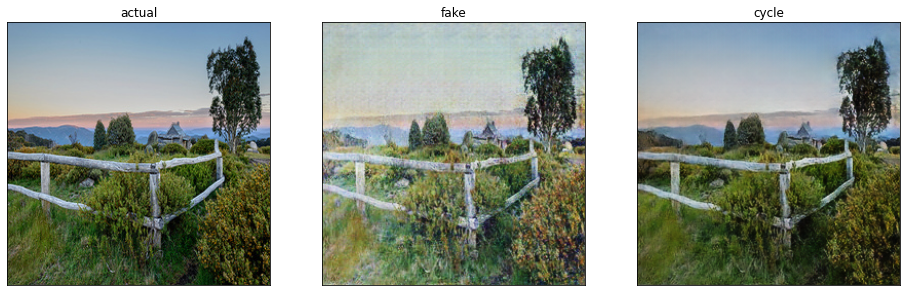

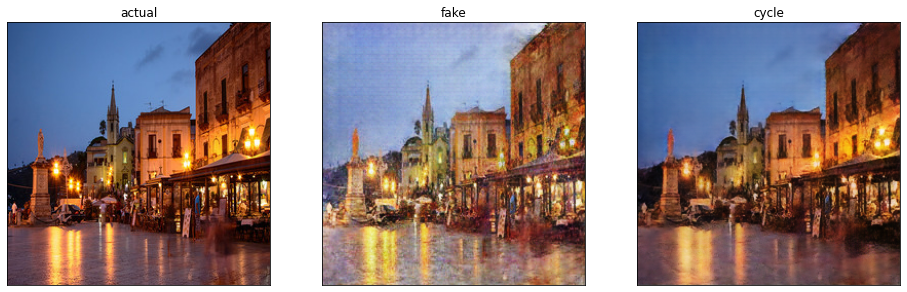

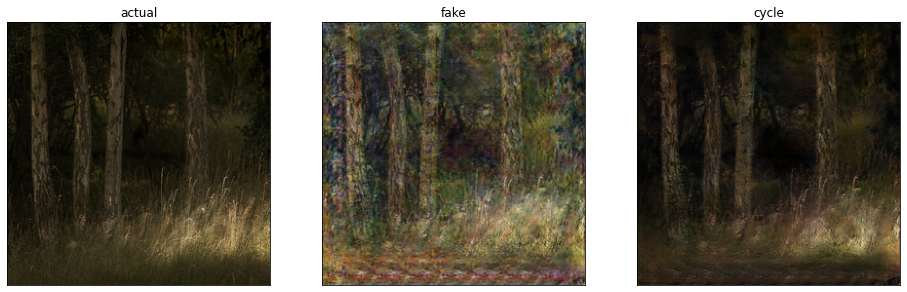

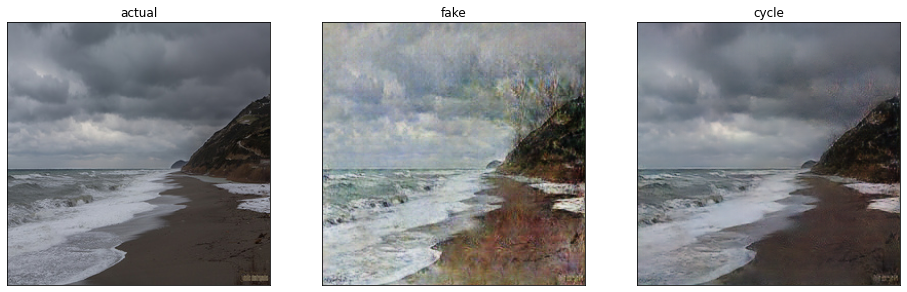

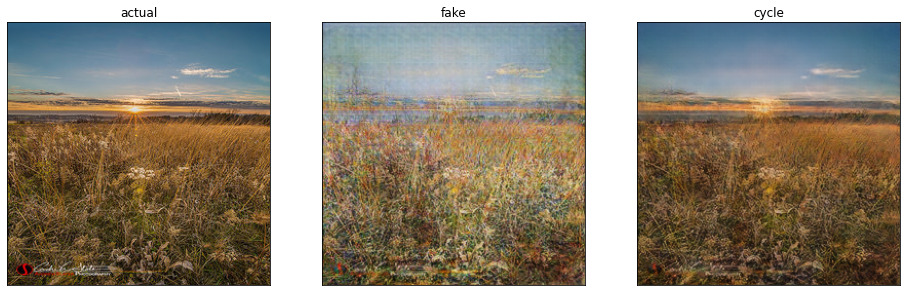

In [43]:
eval_visually(10, 10)